# Introducing:

## Context:
The cleaned data set contains information of price, transmission, mileage, fuel type, road tax, miles per gallon (mpg), and engine size. I've removed duplicate listings and cleaned the columns, but have included a notebook showing the process and the original data for anyone who wants to check/improve my work.

## Task:
*Predict cars price*

## Used libraries:
- pandas
- numpy
- matplotlib
- optuna
- sklearn
- xgboost
- catboost

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,r2_score,mean_squared_error

import optuna
from optuna.visualization.matplotlib import plot_param_importances

# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval


from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Data preparation

In [3]:
df = pd.read_csv('bmw.csv')
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [4]:
df.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

In [5]:
df.columns = ['model', 'year', 'price', 'transmission', 'mileage', 'fuel_type', 'tax',
       'mpg', 'engine_size']

In [6]:
df.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuel_type', 'tax',
       'mpg', 'engine_size'],
      dtype='object')

## Format data

In [7]:
len(df)

10781

### Skips, Nans

In [8]:
df.isna().mean().sort_values(ascending=False)

model           0.0
year            0.0
price           0.0
transmission    0.0
mileage         0.0
fuel_type       0.0
tax             0.0
mpg             0.0
engine_size     0.0
dtype: float64

In [9]:
df.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuel_type        object
tax               int64
mpg             float64
engine_size     float64
dtype: object

In [10]:
df.select_dtypes(include='object')

,model,transmission,fuel_type
0,5 Series,Automatic,Diesel
1,6 Series,Automatic,Petrol
2,5 Series,Automatic,Diesel
3,1 Series,Automatic,Diesel
4,7 Series,Automatic,Diesel
...,...,...,...
10776,X3,Automatic,Diesel
10777,5 Series,Automatic,Diesel
10778,3 Series,Manual,Petrol
10779,1 Series,Automatic,Diesel


## Feature Engineering

### Transform categories into numbers

In [11]:
df.select_dtypes(include='object').head()

,model,transmission,fuel_type
0,5 Series,Automatic,Diesel
1,6 Series,Automatic,Petrol
2,5 Series,Automatic,Diesel
3,1 Series,Automatic,Diesel
4,7 Series,Automatic,Diesel


#### transmission get_dummies

In [12]:
pd.get_dummies(df['transmission'],prefix='is').head()

,is_Automatic,is_Manual,is_Semi-Auto
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False


In [13]:
df_dum_transmission =pd.get_dummies(df['transmission'],prefix='is')
df_dum_transmission.columns = map(str.lower, df_dum_transmission.columns)
df_dum_transmission.head()

,is_automatic,is_manual,is_semi-auto
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False


In [14]:
df = pd.concat([df,df_dum_transmission],axis=1)
df.head()

,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,True,False,False
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,True,False,False
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,True,False,False
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,True,False,False
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,True,False,False


#### fuel_type get_dummies

In [15]:
df_dum_fuel_type =pd.get_dummies(df['fuel_type'],prefix='is')
df_dum_fuel_type.columns = map(str.lower, df_dum_fuel_type.columns)
df_dum_fuel_type.head()

,is_diesel,is_electric,is_hybrid,is_other,is_petrol
0,True,False,False,False,False
1,False,False,False,False,True
2,True,False,False,False,False
3,True,False,False,False,False
4,True,False,False,False,False


In [16]:
df = pd.concat([df,df_dum_fuel_type],axis=1)
df.head()

,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,is_hybrid,is_other,is_petrol
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,True,False,False,True,False,False,False,False
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,True,False,False,False,False,False,False,True
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,True,False,False,True,False,False,False,False
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,True,False,False,True,False,False,False,False
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,True,False,False,True,False,False,False,False


#### model get_dummies

In [17]:
df['model'].value_counts().reset_index()

,model,count
0,3 Series,2443
1,1 Series,1969
2,2 Series,1229
3,5 Series,1056
4,4 Series,995
5,X1,804
6,X3,551
7,X5,468
8,X2,288
9,X4,179


In [18]:
#pd.set_option('display.max_columns', None)

In [19]:
df_dum_model =pd.get_dummies(df['model'],prefix='is')
df_dum_model.columns = map(str.lower, df_dum_model.columns)
df_dum_model.columns = df_dum_model.columns.str.replace(" ", "")
df_dum_model.value_counts().reset_index().T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
is_1series,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
is_2series,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
is_3series,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
is_4series,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
is_5series,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
is_6series,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
is_7series,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
is_8series,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
is_m2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
is_m3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [20]:
df = pd.concat([df,df_dum_model],axis=1)
df.head()

,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,is_automatic,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,True,...,False,False,False,False,False,False,False,False,False,False
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,True,...,False,False,False,False,False,False,False,False,False,False
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,True,...,False,False,False,False,False,False,False,False,False,False
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,True,...,False,False,False,False,False,False,False,False,False,False
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,True,...,False,False,False,False,False,False,False,False,False,False


#### Drop categories variables

In [21]:
df.select_dtypes(include='object').head()

,model,transmission,fuel_type
0,5 Series,Automatic,Diesel
1,6 Series,Automatic,Petrol
2,5 Series,Automatic,Diesel
3,1 Series,Automatic,Diesel
4,7 Series,Automatic,Diesel


In [22]:
df.drop('model', axis = 1,inplace=True)

In [23]:
df.drop('transmission', axis = 1,inplace=True)

In [24]:
df.drop('fuel_type', axis = 1,inplace=True)

In [25]:
df.head()

,year,price,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
0,2014,11200,67068,125,57.6,2.0,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,2018,27000,14827,145,42.8,2.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2016,16000,62794,160,51.4,3.0,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,2017,12750,26676,145,72.4,1.5,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,2014,14500,39554,160,50.4,3.0,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [26]:
df.dtypes

year              int64
price             int64
mileage           int64
tax               int64
mpg             float64
engine_size     float64
is_automatic       bool
is_manual          bool
is_semi-auto       bool
is_diesel          bool
is_electric        bool
is_hybrid          bool
is_other           bool
is_petrol          bool
is_1series         bool
is_2series         bool
is_3series         bool
is_4series         bool
is_5series         bool
is_6series         bool
is_7series         bool
is_8series         bool
is_m2              bool
is_m3              bool
is_m4              bool
is_m5              bool
is_m6              bool
is_x1              bool
is_x2              bool
is_x3              bool
is_x4              bool
is_x5              bool
is_x6              bool
is_x7              bool
is_z3              bool
is_z4              bool
is_i3              bool
is_i8              bool
dtype: object

### Define the X and y variables

In [27]:
X = df.drop("price", axis = 1)
y = df["price"]

In [28]:
X

,year,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
0,2014,67068,125,57.6,2.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2018,14827,145,42.8,2.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2016,62794,160,51.4,3.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2017,26676,145,72.4,1.5,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,2014,39554,160,50.4,3.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10776,2016,40818,150,54.3,2.0,True,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
10777,2016,42947,125,60.1,2.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
10778,2017,25468,200,42.8,2.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10779,2014,45000,30,64.2,2.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
y

0        11200
1        27000
2        16000
3        12750
4        14500
         ...  
10776    19000
10777    14600
10778    13100
10779     9930
10780    15981
Name: price, Length: 10781, dtype: int64

### Split the datasets into train and test sets:
- train 80%
- test 20%

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [31]:
len(X_train) / len(df)

0.7999257953807625

In [32]:
len(X_test) / len(df)

0.20007420461923756

In [33]:
X_train.dtypes

year              int64
mileage           int64
tax               int64
mpg             float64
engine_size     float64
is_automatic       bool
is_manual          bool
is_semi-auto       bool
is_diesel          bool
is_electric        bool
is_hybrid          bool
is_other           bool
is_petrol          bool
is_1series         bool
is_2series         bool
is_3series         bool
is_4series         bool
is_5series         bool
is_6series         bool
is_7series         bool
is_8series         bool
is_m2              bool
is_m3              bool
is_m4              bool
is_m5              bool
is_m6              bool
is_x1              bool
is_x2              bool
is_x3              bool
is_x4              bool
is_x5              bool
is_x6              bool
is_x7              bool
is_z3              bool
is_z4              bool
is_i3              bool
is_i8              bool
dtype: object

In [34]:
X_train

,year,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
3652,2019,9165,145,50.4,2.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
7007,2019,6650,145,37.7,3.0,True,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
9045,2016,64231,145,53.3,3.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3910,2019,2799,135,141.2,1.5,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3635,2013,63583,200,45.6,3.0,True,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,2018,40456,145,64.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
5191,2016,23210,200,39.8,3.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
5390,2019,5652,145,47.9,2.0,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,False
860,2016,14542,125,60.1,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False


### Scales numerical columns:

In [35]:
X_train.describe()

,year,mileage,tax,mpg,engine_size
count,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000
mean,2017.066558,25570.214634,131.228548,56.448991,2.162083
std,2.366897,25163.683316,60.990613,30.949121,0.549266
min,1996.000000,4.000000,0.000000,5.500000,0.000000
25%,2016.000000,5497.250000,125.000000,45.600000,2.000000
50%,2017.000000,18603.000000,145.000000,53.300000,2.000000
75%,2019.000000,38436.500000,145.000000,62.800000,2.000000
max,2020.000000,214000.000000,580.000000,470.800000,6.600000


In [36]:
# Initiate scaler
sc = StandardScaler()

# Standardize the training dataset
X_train = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

# Standardized the testing dataset
X_test = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)

# Summary statistics after standardization
X_train.describe()

,year,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
count,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,...,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03
mean,-3.619286e-14,9.886958e-18,-8.764377e-17,2.008288e-16,-9.501779e-16,1.153478e-17,4.407936e-17,1.647826e-17,5.108262e-17,1.029891e-18,...,-6.591306e-18,6.344132e-17,-1.029891e-17,7.909567e-17,-3.089674e-17,8.239132e-18,1.194674e-17,-4.078370e-17,1.647826e-18,2.554131e-17
std,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,...,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00
min,-8.901011e+00,-1.016055e+00,-2.151744e+00,-1.646313e+00,-3.936540e+00,-7.075373e-01,-5.580641e-01,-8.666406e-01,-1.370235e+00,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
25%,-4.506407e-01,-7.977421e-01,-1.021290e-01,-3.505631e-01,-2.951064e-01,-7.075373e-01,-5.580641e-01,-8.666406e-01,-1.370235e+00,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
50%,-2.812218e-02,-2.768918e-01,2.258093e-01,-1.017533e-01,-2.951064e-01,-7.075373e-01,-5.580641e-01,-8.666406e-01,7.298018e-01,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
75%,8.169149e-01,5.113334e-01,2.258093e-01,2.052200e-01,-2.951064e-01,1.413353e+00,-5.580641e-01,1.153881e+00,7.298018e-01,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
max,1.239433e+00,7.488598e+00,7.358468e+00,1.338891e+01,8.080190e+00,1.413353e+00,1.791909e+00,1.153881e+00,7.298018e-01,6.565821e+01,...,6.054700e+00,4.376018e+00,7.756489e+00,4.677107e+00,1.008299e+01,1.380741e+01,3.789899e+01,9.848858e+00,1.613485e+01,2.573683e+01


In [37]:
X_train.dtypes

year            float64
mileage         float64
tax             float64
mpg             float64
engine_size     float64
is_automatic    float64
is_manual       float64
is_semi-auto    float64
is_diesel       float64
is_electric     float64
is_hybrid       float64
is_other        float64
is_petrol       float64
is_1series      float64
is_2series      float64
is_3series      float64
is_4series      float64
is_5series      float64
is_6series      float64
is_7series      float64
is_8series      float64
is_m2           float64
is_m3           float64
is_m4           float64
is_m5           float64
is_m6           float64
is_x1           float64
is_x2           float64
is_x3           float64
is_x4           float64
is_x5           float64
is_x6           float64
is_x7           float64
is_z3           float64
is_z4           float64
is_i3           float64
is_i8           float64
dtype: object

# XGBoost

## xgb default params

In [38]:
xgb_model_1 = XGBRegressor()

In [39]:
xgb_model_1.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
%%time

y_pred = xgb_model_1.predict(X_test)

CPU times: user 35.2 ms, sys: 5.12 ms, total: 40.3 ms
Wall time: 12.2 ms


In [41]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))
print("R^2 : ", r2_score(y_test, y_pred))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

MAPE : 0.07236994717154145
MAE : 1571.0423867513473
R^2 :  0.9478130262606779
RMSE: 2597.798825489239


In [42]:
xgb_pred_1 = xgb_model_1.predict(X_test)

In [43]:
X_test['xgb_pred_1_price'] = xgb_model_1.predict(X_test)

In [44]:
X_test['xgb_pred_1_price'].reset_index()

,index,xgb_pred_1_price
0,8728,13462.662109
1,761,13168.717773
2,7209,41202.503906
3,6685,21551.142578
4,8548,16178.983398
...,...,...
2152,10677,13533.466797
2153,8418,10782.321289
2154,1702,22187.761719
2155,6965,47273.484375


In [45]:
X_test['xgb_pred_1_price_err'] = X_test['xgb_pred_1_price'] - y_test

In [46]:
X_test['xgb_pred_1_price_err'].reset_index()

,index,xgb_pred_1_price_err
0,8728,-1837.337891
1,761,-2326.282227
2,7209,1327.503906
3,6685,-178.857422
4,8548,2379.983398
...,...,...
2152,10677,1533.466797
2153,8418,-976.678711
2154,1702,727.761719
2155,6965,-5717.515625


In [47]:
X_test['price_pred_1_percent_err'] =(( - (100 - ((X_test['xgb_pred_1_price']  / y_test) * 100))) / 100)

In [48]:
submission = {
    'price': y_test,
    'xgb_pred_1_price': xgb_pred_1,
    'xgb_pred_1_price_err': X_test['xgb_pred_1_price_err'],
    'xgb_pred_1_price_percent_err': X_test['price_pred_1_percent_err']
}
solution1 = pd.DataFrame(submission)
solution1.head(10)\
.reset_index().style.format({
    'xgb_pred_1_price_percent_err': '{:%}',

    'price': '£{0:,.0f}',
    'xgb_pred_1_price': '£{0:,.0f}',
    'xgb_pred_1_price_err': '£{0:,.0f}',
})
#solution.to_csv('submission.csv',index=False)

,index,price,xgb_pred_1_price,xgb_pred_1_price_err,xgb_pred_1_price_percent_err
0,8728,"£15,300","£13,463","£-1,837",-12.008744%
1,761,"£15,495","£13,169","£-2,326",-15.013115%
2,7209,"£39,875","£41,203","£1,328",3.329163%
3,6685,"£21,730","£21,551",£-179,-0.823090%
4,8548,"£13,799","£16,179","£2,380",17.247506%
5,9385,"£24,499","£26,030","£1,531",6.248142%
6,6085,"£42,202","£45,914","£3,712",8.796023%
7,1885,"£32,400","£30,026","£-2,374",-7.326781%
8,4921,"£28,990","£27,965","£-1,025",-3.535210%
9,1121,"£15,790","£18,013","£2,223",14.075463%


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [50]:
len(X_train) / len(df)

0.7999257953807625

In [51]:
len(X_test) / len(df)

0.20007420461923756

In [52]:
X_test

,year,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
8728,2018,36469,150,50.4,1.5,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
761,2014,51565,160,51.4,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
7209,2019,8988,150,36.7,3.0,False,False,True,True,False,...,False,True,False,False,False,False,False,False,False,False
6685,2019,5054,145,39.2,1.5,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8548,2018,13369,145,65.7,1.5,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,2016,57918,125,58.9,2.0,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
8418,2016,55987,20,70.6,1.5,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1702,2019,7710,145,60.1,2.0,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
6965,2020,4360,135,5.5,2.0,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False


### Scales numerical columns:

In [53]:
# Initiate scaler
sc = StandardScaler()

# Standardize the training dataset
X_train = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

# Standardized the testing dataset
X_test = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)

# Summary statistics after standardization
X_train.describe()

,year,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
count,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,...,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03
mean,-3.619286e-14,9.886958e-18,-8.764377e-17,2.008288e-16,-9.501779e-16,1.153478e-17,4.407936e-17,1.647826e-17,5.108262e-17,1.029891e-18,...,-6.591306e-18,6.344132e-17,-1.029891e-17,7.909567e-17,-3.089674e-17,8.239132e-18,1.194674e-17,-4.078370e-17,1.647826e-18,2.554131e-17
std,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,...,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00
min,-8.901011e+00,-1.016055e+00,-2.151744e+00,-1.646313e+00,-3.936540e+00,-7.075373e-01,-5.580641e-01,-8.666406e-01,-1.370235e+00,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
25%,-4.506407e-01,-7.977421e-01,-1.021290e-01,-3.505631e-01,-2.951064e-01,-7.075373e-01,-5.580641e-01,-8.666406e-01,-1.370235e+00,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
50%,-2.812218e-02,-2.768918e-01,2.258093e-01,-1.017533e-01,-2.951064e-01,-7.075373e-01,-5.580641e-01,-8.666406e-01,7.298018e-01,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
75%,8.169149e-01,5.113334e-01,2.258093e-01,2.052200e-01,-2.951064e-01,1.413353e+00,-5.580641e-01,1.153881e+00,7.298018e-01,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
max,1.239433e+00,7.488598e+00,7.358468e+00,1.338891e+01,8.080190e+00,1.413353e+00,1.791909e+00,1.153881e+00,7.298018e-01,6.565821e+01,...,6.054700e+00,4.376018e+00,7.756489e+00,4.677107e+00,1.008299e+01,1.380741e+01,3.789899e+01,9.848858e+00,1.613485e+01,2.573683e+01


## xgb grid_search

In [56]:
xgb_model_2 = XGBRegressor()

In [57]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.03, 0.05, 0.1],
           'n_estimators': [100,500,700],
           'colsample_bytree': [0.3, 0.7]}

In [59]:
clf = GridSearchCV(
    estimator=xgb_model_2, 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    verbose=1
)

# Pause

# Pause

# Pause

In [60]:
%%time

clf.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
CPU times: user 25min 15s, sys: 9.99 s, total: 25min 25s
Wall time: 3min 31s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.03, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 500, 700]},
             scoring='neg_mean_squared_error', verbose=1)

In [61]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 700}
Lowest RMSE:  2504.3196688921967


In [62]:
clf.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 6,
 'n_estimators': 700}

In [63]:
parameters = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.03,
    'max_depth': 6,
    'n_estimators': 700,
    'seed' :42,
    'eval_metric': 'mape'
}

In [64]:
xgb_model_2 = XGBRegressor(**parameters)

In [65]:
xgb_model_2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [66]:
%%time

y_pred2 = xgb_model_2.predict(X_test)

CPU times: user 90.7 ms, sys: 0 ns, total: 90.7 ms
Wall time: 23.7 ms


In [67]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred2))
print("MAE :", mean_absolute_error(y_test,y_pred2))
print("R^2 : ", r2_score(y_test, y_pred2))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred2)))

MAPE : 0.0696538008255192
MAE : 1525.7091141419107
R^2 :  0.9475496696872301
RMSE: 2604.3453484824827


## xgb model 3

In [68]:
xgb_model_3 = XGBRegressor()

In [72]:
parameters = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mape',
    'max_depth': 6,
    'learning_rate': 0.03,
    'n_estimators': 3000,
    'early_stopping_rounds': 30,
    'verbosity':0,
    #'min_child_weight':
    #'gamma':
    'subsample':.7,
    'colsample_bytree': 0.7,
    'reg_alpha':0,
    'reg_lambda':1,
    'random_state':42,
    'verbose_eval':False
}

In [73]:
xgb_model_3 = XGBRegressor(**parameters)

In [74]:
%%time

xgb_model_3.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-mape:0.44765
[1]	validation_0-mape:0.43911
[2]	validation_0-mape:0.42773
[3]	validation_0-mape:0.41657
[4]	validation_0-mape:0.40609
[5]	validation_0-mape:0.39665
[6]	validation_0-mape:0.38647
[7]	validation_0-mape:0.37679
[8]	validation_0-mape:0.36762
[9]	validation_0-mape:0.35861
[10]	validation_0-mape:0.34987
[11]	validation_0-mape:0.34175
[12]	validation_0-mape:0.33348
[13]	validation_0-mape:0.32609
[14]	validation_0-mape:0.31830
[15]	validation_0-mape:0.31068
[16]	validation_0-mape:0.30324
[17]	validation_0-mape:0.29629
[18]	validation_0-mape:0.28961
[19]	validation_0-mape:0.28307
[20]	validation_0-mape:0.27676
[21]	validation_0-mape:0.27063
[22]	validation_0-mape:0.26459
[23]	validation_0-mape:0.25893
[24]	validation_0-mape:0.25386
[25]	validation_0-mape:0.24850
[26]	validation_0-mape:0.24333
[27]	validation_0-mape:0.23827
[28]	validation_0-mape:0.23379
[29]	validation_0-mape:0.22898
[30]	validation_0-mape:0.22441
[31]	validation_0-mape:0.22008
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [75]:
y_pred3 = xgb_model_3.predict(X_test)

In [76]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred3))
print("MAE :", mean_absolute_error(y_test,y_pred3))
print("R^2 : ", r2_score(y_test, y_pred3))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred3)))

MAPE : 0.06946570785814532
MAE : 1511.212333583699
R^2 :  0.9472617476126112
RMSE: 2611.48374272232


## xgboost optuna

# model 4 Optuna to tune the XGBRegressor model

In [77]:
xgb_model_4 = XGBRegressor()

In [78]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0)
    }
    xgb_model_4 = XGBRegressor(**param)
    xgb_model_4.fit(X_train, y_train)
    y_pred = xgb_model_4.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [79]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [80]:
study = optuna.create_study(direction='minimize', study_name='regression')

In [81]:
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [82]:
print('Best parameters', study.best_params)

Best parameters {'max_depth': 8, 'learning_rate': 0.010550601736607781, 'n_estimators': 888, 'min_child_weight': 2, 'gamma': 0.8638289148927748, 'subsample': 0.5770672680093962, 'colsample_bytree': 0.5289666950496272, 'reg_alpha': 0.8880478879806091, 'reg_lambda': 0.3138292996388423}


In [83]:
print('Best value', study.best_value)

Best value 6441869.6753636645


In [84]:
print('Best trial', study.best_trial)

Best trial FrozenTrial(number=55, state=TrialState.COMPLETE, values=[6441869.6753636645], datetime_start=datetime.datetime(2023, 11, 29, 18, 26, 53, 409465), datetime_complete=datetime.datetime(2023, 11, 29, 18, 26, 55, 63838), params={'max_depth': 8, 'learning_rate': 0.010550601736607781, 'n_estimators': 888, 'min_child_weight': 2, 'gamma': 0.8638289148927748, 'subsample': 0.5770672680093962, 'colsample_bytree': 0.5289666950496272, 'reg_alpha': 0.8880478879806091, 'reg_lambda': 0.3138292996388423}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=300, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.01, step=

/tmp/ipykernel_12881/2122237422.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


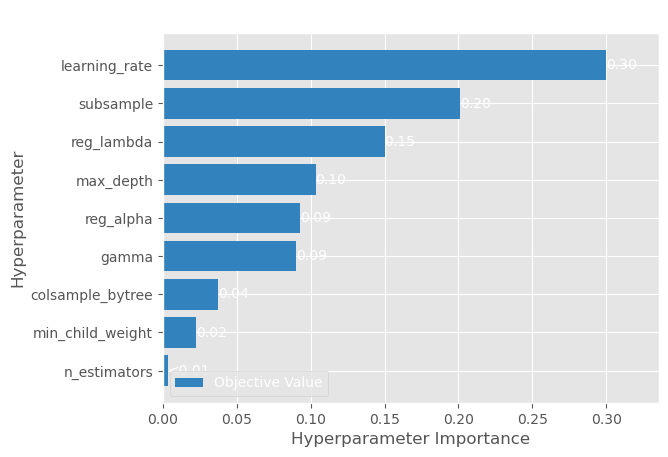

In [85]:
plot_param_importances(study);

## Use the optimal hyperparameters to train the model

In [86]:
xgb_model_4 = XGBRegressor(**study.best_params)

In [87]:
xgb_model_4.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5289666950496272, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.8638289148927748,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010550601736607781,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=888, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [88]:
y_pred4 = xgb_model_4.predict(X_test)

In [89]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred4))
print("MAE :", mean_absolute_error(y_test,y_pred4))
print("R^2 : ", r2_score(y_test, y_pred4))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred4)))

MAPE : 0.07076713431071285
MAE : 1522.2178800580232
R^2 :  0.9501846695500122
RMSE: 2538.0838590093244


## xgb model 5

In [90]:
parameters = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mape',
    'max_depth': 10,
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'early_stopping_rounds': 30,
    'verbosity':0,
    'min_child_weight':10,
    'gamma': 0.18,
    'subsample':0.8,
    'colsample_bytree': 0.5,
    'reg_alpha':0.8,
    'reg_lambda':0.47,
    'random_state':42
}

In [91]:
xgb_model_5 = XGBRegressor(**parameters)

In [92]:
xgb_model_5.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-mape:0.45580
[1]	validation_0-mape:0.45291
[2]	validation_0-mape:0.44902
[3]	validation_0-mape:0.44509
[4]	validation_0-mape:0.44110
[5]	validation_0-mape:0.43794
[6]	validation_0-mape:0.43398
[7]	validation_0-mape:0.43065
[8]	validation_0-mape:0.42798
[9]	validation_0-mape:0.42430
[10]	validation_0-mape:0.42200
[11]	validation_0-mape:0.41844
[12]	validation_0-mape:0.41470
[13]	validation_0-mape:0.41120
[14]	validation_0-mape:0.40934
[15]	validation_0-mape:0.40574
[16]	validation_0-mape:0.40206
[17]	validation_0-mape:0.39855
[18]	validation_0-mape:0.39556
[19]	validation_0-mape:0.39215
[20]	validation_0-mape:0.38876
[21]	validation_0-mape:0.38561
[22]	validation_0-mape:0.38218
[23]	validation_0-mape:0.37902
[24]	validation_0-mape:0.37575
[25]	validation_0-mape:0.37287
[26]	validation_0-mape:0.37010
[27]	validation_0-mape:0.36686
[28]	validation_0-mape:0.36392
[29]	validation_0-mape:0.36105
[30]	validation_0-mape:0.35816
[31]	validation_0-mape:0.35518
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=0.18, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [93]:
y_pred5 = xgb_model_5.predict(X_test)

In [94]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred5))
print("MAE :", mean_absolute_error(y_test,y_pred5))
print("R^2 : ", r2_score(y_test, y_pred5))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred5)))

MAPE : 0.069423272604554
MAE : 1512.1902457048454
R^2 :  0.9488029054009365
RMSE: 2573.0434338258683


## xgb model 6

In [95]:
xgb_model_6 = XGBRegressor()

In [96]:
parameters = {
    'objective': 'reg:squarederror',
    'eval_metric': 'logloss',
    'max_depth': 10,
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'early_stopping_rounds': 30,
    'verbosity':0,
    'min_child_weight':10,
    'gamma': 0.18,
    'subsample':0.8,
    'colsample_bytree': 0.5,
    'reg_alpha':0.8,
    'reg_lambda':0.47,
    'random_state':42
}

In [97]:
xgb_model_6 = XGBRegressor(**parameters)

In [98]:
xgb_model_6.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-logloss:-1077560.51176
[1]	validation_0-logloss:-1077597.61885
[2]	validation_0-logloss:-1077646.36701
[3]	validation_0-logloss:-1077695.78176
[4]	validation_0-logloss:-1077744.61821
[5]	validation_0-logloss:-1077774.16306
[6]	validation_0-logloss:-1077820.26271
[7]	validation_0-logloss:-1077852.31865
[8]	validation_0-logloss:-1077884.12702
[9]	validation_0-logloss:-1077924.94444
[10]	validation_0-logloss:-1077957.67333
[11]	validation_0-logloss:-1077999.24450
[12]	validation_0-logloss:-1078040.91628
[13]	validation_0-logloss:-1078074.14382
[14]	validation_0-logloss:-1078101.41126
[15]	validation_0-logloss:-1078140.77452
[16]	validation_0-logloss:-1078179.13628
[17]	validation_0-logloss:-1078210.07622
[18]	validation_0-logloss:-1078245.51289
[19]	validation_0-logloss:-1078281.06340
[20]	validation_0-logloss:-1078314.91583
[21]	validation_0-logloss:-1078345.13831
[22]	validation_0-logloss:-1078379.35113
[23]	validation_0-logloss:-1078409.63560
[24]	validation_0-logloss:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='logloss',
             feature_types=None, gamma=0.18, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3000,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [99]:
y_pred6 = xgb_model_6.predict(X_test)

In [100]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred6))
print("MAE :", mean_absolute_error(y_test,y_pred6))
print("R^2 : ", r2_score(y_test, y_pred6))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred6)))

MAPE : 0.07499491323642145
MAE : 1615.5751723358903
R^2 :  0.9416559902895059
RMSE: 2746.7719001215223


## xgb model 7

In [101]:
xgb_model_7 = XGBRegressor()

In [102]:
parameters = {
    'silent':1,
    'objective': 'reg:squarederror',
    'eval_metric': 'mape',
    'max_depth': 9,
    'learning_rate': 0.01,
    'n_estimators': 5000,
    'early_stopping_rounds': 30,
    'verbosity':0,
    'min_child_weight':1,
    'gamma': 0.9481,
    'subsample':0.5373,
    'colsample_bytree': 0.6,
    'reg_alpha':0.9,
    'reg_lambda':0.12,
    'random_state':42
}

In [103]:
xgb_model_7 = XGBRegressor(**parameters)

In [104]:
xgb_model_7.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-mape:0.45567
[1]	validation_0-mape:0.45258
[2]	validation_0-mape:0.44841
[3]	validation_0-mape:0.44449
[4]	validation_0-mape:0.44058
[5]	validation_0-mape:0.43685
[6]	validation_0-mape:0.43285
[7]	validation_0-mape:0.42926
[8]	validation_0-mape:0.42567
[9]	validation_0-mape:0.42199
[10]	validation_0-mape:0.41825
[11]	validation_0-mape:0.41465
[12]	validation_0-mape:0.41089
[13]	validation_0-mape:0.40745
[14]	validation_0-mape:0.40394
[15]	validation_0-mape:0.40035
[16]	validation_0-mape:0.39676
[17]	validation_0-mape:0.39332
[18]	validation_0-mape:0.38985
[19]	validation_0-mape:0.38657
[20]	validation_0-mape:0.38321
[21]	validation_0-mape:0.37997
[22]	validation_0-mape:0.37659
[23]	validation_0-mape:0.37338
[24]	validation_0-mape:0.37021
[25]	validation_0-mape:0.36714
[26]	validation_0-mape:0.36403
[27]	validation_0-mape:0.36084
[28]	validation_0-mape:0.35794
[29]	validation_0-mape:0.35488
[30]	validation_0-mape:0.35178
[31]	validation_0-mape:0.34887
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=0.9481, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [105]:
y_pred7 = xgb_model_7.predict(X_test)

In [106]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred7))
print("MAE :", mean_absolute_error(y_test,y_pred7))
print("R^2 : ", r2_score(y_test, y_pred7))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred7)))

MAPE : 0.06911958174304214
MAE : 1491.8613852835608
R^2 :  0.9508646285805493
RMSE: 2520.702435899783


## xgb model 8

In [107]:
xgb_model_8 = XGBRegressor()

In [108]:
parameters = {
    'verbose':False,
    'eval_metric': 'mape',
    'max_depth': 7,
    'learning_rate': 0.01,
    'n_estimators': 5000,
    'early_stopping_rounds': 30,
    'min_child_weight':1,
    'gamma': 0.29,
    'subsample':0.64,
    'colsample_bytree': 0.6,
    'reg_alpha':0.57,
    'reg_lambda':0.92,
    'random_state':42
}

In [109]:
xgb_model_8 = XGBRegressor(**parameters)

In [110]:
xgb_model_8.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-mape:0.45572
[1]	validation_0-mape:0.45272
[2]	validation_0-mape:0.44870
[3]	validation_0-mape:0.44492
[4]	validation_0-mape:0.44110
[5]	validation_0-mape:0.43766
[6]	validation_0-mape:0.43377
[7]	validation_0-mape:0.43027
[8]	validation_0-mape:0.42677


/home/antonius/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:37:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-mape:0.42325
[10]	validation_0-mape:0.41961
[11]	validation_0-mape:0.41609
[12]	validation_0-mape:0.41244
[13]	validation_0-mape:0.40914
[14]	validation_0-mape:0.40573
[15]	validation_0-mape:0.40222
[16]	validation_0-mape:0.39869
[17]	validation_0-mape:0.39535
[18]	validation_0-mape:0.39197
[19]	validation_0-mape:0.38870
[20]	validation_0-mape:0.38547
[21]	validation_0-mape:0.38227
[22]	validation_0-mape:0.37900
[23]	validation_0-mape:0.37589
[24]	validation_0-mape:0.37278
[25]	validation_0-mape:0.36987
[26]	validation_0-mape:0.36683
[27]	validation_0-mape:0.36374
[28]	validation_0-mape:0.36087
[29]	validation_0-mape:0.35788
[30]	validation_0-mape:0.35486
[31]	validation_0-mape:0.35205
[32]	validation_0-mape:0.34980
[33]	validation_0-mape:0.34858
[34]	validation_0-mape:0.34704
[35]	validation_0-mape:0.34446
[36]	validation_0-mape:0.34226
[37]	validation_0-mape:0.33940
[38]	validation_0-mape:0.33664
[39]	validation_0-mape:0.33384
[40]	validation_0-mape:0.33216
[41]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=0.29, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [111]:
y_pred8 = xgb_model_8.predict(X_test)

In [112]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred8))
print("MAE :", mean_absolute_error(y_test,y_pred8))
print("R^2 : ", r2_score(y_test, y_pred8))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred8)))

MAPE : 0.06882816187228817
MAE : 1492.2402481836027
R^2 :  0.9496492022809297
RMSE: 2551.6883876388124


# CatBoost

## cbt default params 

In [113]:
parameters = {
    'eval_metric': 'MAPE',
    'random_seed':42,
    'verbose':100
}

In [114]:
model_cbt_1 = CatBoostRegressor(**parameters)

In [115]:
model_cbt_1.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

Learning rate set to 0.071417
0:	learn: 0.4582005	test: 0.4346392	best: 0.4346392 (0)	total: 49.6ms	remaining: 49.6s
100:	learn: 0.0891548	test: 0.0919566	best: 0.0919566 (100)	total: 230ms	remaining: 2.04s
200:	learn: 0.0761355	test: 0.0814863	best: 0.0814863 (200)	total: 424ms	remaining: 1.68s
300:	learn: 0.0698218	test: 0.0773384	best: 0.0773384 (300)	total: 640ms	remaining: 1.49s
400:	learn: 0.0661798	test: 0.0748715	best: 0.0748715 (400)	total: 864ms	remaining: 1.29s
500:	learn: 0.0636385	test: 0.0735256	best: 0.0735256 (500)	total: 1.1s	remaining: 1.09s
600:	learn: 0.0616335	test: 0.0725534	best: 0.0725534 (600)	total: 1.34s	remaining: 888ms
700:	learn: 0.0604273	test: 0.0720716	best: 0.0720716 (700)	total: 1.57s	remaining: 671ms
800:	learn: 0.0589640	test: 0.0714491	best: 0.0714491 (800)	total: 1.8s	remaining: 446ms
900:	learn: 0.0576734	test: 0.0708522	best: 0.0708509 (899)	total: 2.02s	remaining: 222ms
999:	learn: 0.0565326	test: 0.0705305	best: 0.0705305 (999)	total: 2.23s	re

In [116]:
y_pred_cbt_1 = model_cbt_1.predict(X_test)

In [117]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred_cbt_1))
print("MAE :", mean_absolute_error(y_test,y_pred_cbt_1))
print("R^2 : ", r2_score(y_test, y_pred_cbt_1))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_cbt_1)))

MAPE : 0.07053052880606142
MAE : 1517.6795025968347
R^2 :  0.9501121005410178
RMSE: 2539.9318764643426


## model_cbt_2

In [118]:
parameters = {
    'iterations':15000,
    'verbose':200,
    'od_type' : "Iter",
    'od_wait' : 500,
    'eval_metric': 'MAPE',
    'random_seed':42
}

In [119]:
model_cbt_2 = CatBoostRegressor(**parameters)

In [120]:
model_cbt_2.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

Learning rate set to 0.013689
0:	learn: 0.4795051	test: 0.4548565	best: 0.4548565 (0)	total: 2.52ms	remaining: 37.8s
200:	learn: 0.1345092	test: 0.1326621	best: 0.1326621 (200)	total: 452ms	remaining: 33.3s
400:	learn: 0.0971293	test: 0.0995247	best: 0.0995247 (400)	total: 889ms	remaining: 32.4s
600:	learn: 0.0859170	test: 0.0897756	best: 0.0897756 (600)	total: 1.34s	remaining: 32.2s
800:	learn: 0.0801438	test: 0.0850595	best: 0.0850595 (800)	total: 1.77s	remaining: 31.3s
1000:	learn: 0.0763859	test: 0.0822070	best: 0.0822070 (1000)	total: 2.13s	remaining: 29.8s
1200:	learn: 0.0733746	test: 0.0799329	best: 0.0799329 (1200)	total: 2.49s	remaining: 28.7s
1400:	learn: 0.0711323	test: 0.0783141	best: 0.0783141 (1400)	total: 2.93s	remaining: 28.5s
1600:	learn: 0.0692432	test: 0.0769628	best: 0.0769628 (1600)	total: 3.39s	remaining: 28.4s
1800:	learn: 0.0677686	test: 0.0759532	best: 0.0759532 (1800)	total: 3.88s	remaining: 28.4s
2000:	learn: 0.0666620	test: 0.0752539	best: 0.0752539 (2000)	t

In [121]:
y_pred_cbt_2 = model_cbt_2.predict(X_test)

In [122]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred_cbt_2))
print("MAE :", mean_absolute_error(y_test,y_pred_cbt_2))
print("R^2 : ", r2_score(y_test, y_pred_cbt_2))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_cbt_2)))

MAPE : 0.0685213617510581
MAE : 1483.8261345759083
R^2 :  0.9495945086894222
RMSE: 2553.0738981933446


## model_cbt_3_loss_funcMAE 

In [123]:
parameters = {
    'iterations':10000,
    'verbose':500,
    'od_type' : "Iter",
    'od_wait' : 500,
    'eval_metric': 'MAPE',
    'loss_function': 'MAE',
    'random_seed':42
}

In [124]:
model_cbt_3_loss_funcMAE = CatBoostRegressor(**parameters)

In [125]:
model_cbt_3_loss_funcMAE.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

0:	learn: 0.4124760	test: 0.3958300	best: 0.3958300 (0)	total: 2.27ms	remaining: 22.7s
500:	learn: 0.0693833	test: 0.0767474	best: 0.0767474 (500)	total: 1.04s	remaining: 19.7s
1000:	learn: 0.0600680	test: 0.0709185	best: 0.0709185 (1000)	total: 2.09s	remaining: 18.8s
1500:	learn: 0.0560336	test: 0.0692118	best: 0.0692113 (1499)	total: 3.12s	remaining: 17.7s
2000:	learn: 0.0536847	test: 0.0684875	best: 0.0684857 (1987)	total: 4.14s	remaining: 16.5s
2500:	learn: 0.0521229	test: 0.0681033	best: 0.0681033 (2500)	total: 5.19s	remaining: 15.6s
3000:	learn: 0.0509709	test: 0.0678706	best: 0.0678705 (2996)	total: 6.21s	remaining: 14.5s
3500:	learn: 0.0499984	test: 0.0677769	best: 0.0677721 (3411)	total: 7.24s	remaining: 13.4s
4000:	learn: 0.0490984	test: 0.0676675	best: 0.0676675 (4000)	total: 8.27s	remaining: 12.4s
4500:	learn: 0.0485094	test: 0.0676221	best: 0.0676096 (4472)	total: 9.29s	remaining: 11.3s
5000:	learn: 0.0479537	test: 0.0675044	best: 0.0675008 (4993)	total: 10.3s	remaining: 1

In [126]:
y_pred_cbt_3 = model_cbt_3_loss_funcMAE.predict(X_test)

In [127]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred_cbt_3))
print("MAE :", mean_absolute_error(y_test,y_pred_cbt_3))
print("R^2 : ", r2_score(y_test, y_pred_cbt_3))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_cbt_3)))

MAPE : 0.06722759466581049
MAE : 1479.3452148551714
R^2 :  0.945959379461103
RMSE: 2643.532311457623


## model_ cbt_4

In [128]:
parameters = {
    'iterations':30000,
    'learning_rate': 0.01,
    'verbose':300,
    'od_type' : "Iter",
    'od_wait' : 500,
    'eval_metric': 'MAPE',
    'loss_function': 'MAE',
    'random_seed':42
}

In [129]:
model_cbt_4 = CatBoostRegressor(**parameters)

In [130]:
model_cbt_4.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

0:	learn: 0.4188856	test: 0.4019143	best: 0.4019143 (0)	total: 3.5ms	remaining: 1m 45s
300:	learn: 0.1142091	test: 0.1138834	best: 0.1138834 (300)	total: 805ms	remaining: 1m 19s
600:	learn: 0.0850885	test: 0.0895934	best: 0.0895934 (600)	total: 1.51s	remaining: 1m 13s
900:	learn: 0.0776049	test: 0.0836341	best: 0.0836341 (900)	total: 2.21s	remaining: 1m 11s
1200:	learn: 0.0725335	test: 0.0794316	best: 0.0794316 (1200)	total: 2.82s	remaining: 1m 7s
1500:	learn: 0.0690252	test: 0.0768877	best: 0.0768877 (1500)	total: 3.42s	remaining: 1m 4s
1800:	learn: 0.0661071	test: 0.0749342	best: 0.0749342 (1800)	total: 4.03s	remaining: 1m 3s
2100:	learn: 0.0639203	test: 0.0734477	best: 0.0734477 (2100)	total: 4.64s	remaining: 1m 1s
2400:	learn: 0.0622112	test: 0.0724260	best: 0.0724260 (2400)	total: 5.26s	remaining: 1m
2700:	learn: 0.0608320	test: 0.0716583	best: 0.0716583 (2700)	total: 5.87s	remaining: 59.3s
3000:	learn: 0.0596554	test: 0.0710926	best: 0.0710920 (2999)	total: 6.47s	remaining: 58.3s

In [131]:
y_pred_cbt_4 = model_cbt_4.predict(X_test)

In [132]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred_cbt_4))
print("MAE :", mean_absolute_error(y_test,y_pred_cbt_4))
print("R^2 : ", r2_score(y_test, y_pred_cbt_4))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_cbt_4)))

MAPE : 0.06794804973367537
MAE : 1488.3959583557069
R^2 :  0.9455333414907741
RMSE: 2653.9322115909226


# Summary: 

In [133]:
result = { 'metrics':['MAPE','MAE','R^2','RMSE'],
          'xgb_model_1':
              [0.07357927339234972,
               1590.7259413392444,
               0.9407670091533626,
               2767.618917194323],
          'xgb_model_2':
              [0.07124221072034015,
               1537.37592715713,
               0.9451938676408683,
               2662.1899342660677],
           'xgb_model_3':
              [0.06932622451623494,
               1512.159816581008,
               0.9469964609967729,
               2618.0437120858437],          
           'xgb_model_4':
              [0.06904232532519261,
                1486.4276104371306,
                0.9510177642453841,
                2516.771350596266],
           'xgb_model_5':
              [0.06930807552542517,
                1509.3340570399425,
                0.9488833273047319,
                2571.021733380101],
           'xgb_model_6':
              [0.07160324988547503,
                1560.2753878519609,
                0.9449132559197255,
                2668.996544032309],
           'xgb_model_7':
              [0.06931300810925882,
                1490.535134857984,
                0.948954759303425,
                2569.2246932272983],
           'xgb_model_8':
              [0.06922967159668524,
                1495.860444600791,
                0.9486400536921809,
                2577.1324532870935],
           'model_cbt_1':
              [0.07053052880606142,
                1517.6795025968347,
                0.9501121005410178,
                2539.9318764643426],
           'model_cbt_2':
              [0.0685213617510581,
                1483.8261345759083,
                0.9495945086894222,
                2553.0738981933446],
           'model_cbt_3':
              [0.06722759466581049,
                1479.3452148551714,
                0.945959379461103,
                2643.532311457623],
           'model_cbt_4':
              [0.06794804973367537,
                1488.3959583557069,
                0.9455333414907741,
                2653.9322115909226]
}

In [134]:
result_df = pd.DataFrame.from_dict(result)
result_df.T

,0,1,2,3
metrics,MAPE,MAE,R^2,RMSE
xgb_model_1,0.073579,1590.725941,0.940767,2767.618917
xgb_model_2,0.071242,1537.375927,0.945194,2662.189934
xgb_model_3,0.069326,1512.159817,0.946996,2618.043712
xgb_model_4,0.069042,1486.42761,0.951018,2516.771351
xgb_model_5,0.069308,1509.334057,0.948883,2571.021733
xgb_model_6,0.071603,1560.275388,0.944913,2668.996544
xgb_model_7,0.069313,1490.535135,0.948955,2569.224693
xgb_model_8,0.06923,1495.860445,0.94864,2577.132453
model_cbt_1,0.070531,1517.679503,0.950112,2539.931876
